# Question 2: K-Nearest Neighbor Classifier Hyperparameter Tuning
Implement k-nearest neighbor classifier and tune the hyperparameter k for the range:
k = {1, 3, 5, 7, 9, 11}

Find the value of k for which each performance metric is optimal across all datasets:
- Iris dataset
- Pima dataset
- Haberman dataset
- Ecoli dataset
- Glass dataset
- Kdd dataset

Performance Metrics:
- Accuracy
- Precision
- Recall
- AUC
- G-Mean
- False Alarm Rate

## Import Required Libraries

In [28]:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from io import BytesIO, StringIO
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Dataset Download and Preparation

In [29]:
# Local dataset zip files (in parent directory)
import os

# Get the parent directory where zip files are located
parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, 'data')
os.makedirs(data_dir, exist_ok=True)

DATASET_ZIPS = {
    "iris": os.path.join(parent_dir, "iris-5-fold.zip"),
    "pima": os.path.join(parent_dir, "pima-5-fold.zip"),
    "haberman": os.path.join(parent_dir, "haberman-5-fold.zip"),
    "ecoli": os.path.join(parent_dir, "ecoli-5-fold.zip"),
    "glass": os.path.join(parent_dir, "glass-5-fold.zip")
}

# K values to test
K_VALUES = [1, 3, 5, 7, 9, 11]

def extract_local_zip(dataset_name, zip_path, extract_dir='./data'):
    """Extract a local zip file."""
    dataset_dir = os.path.join(extract_dir, dataset_name)
    
    if os.path.exists(dataset_dir) and len(os.listdir(dataset_dir)) > 0:
        print(f"Dataset '{dataset_name}' already extracted.")
        return dataset_dir
    
    if not os.path.exists(zip_path):
        print(f"Error: Zip file not found at {zip_path}")
        return None
    
    print(f"Extracting {dataset_name}...")
    try:
        os.makedirs(dataset_dir, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(dataset_dir)
        print(f"Successfully extracted to '{dataset_dir}'")
        print(f"  Contents: {os.listdir(dataset_dir)[:5]}")  # Show first 5 files
    except Exception as e:
        print(f"Error extracting {dataset_name}: {e}")
        return None
    
    return dataset_dir

def read_keel_dat(file_path):
    """Reads a KEEL .dat file, ignoring metadata and parsing the data."""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
            # Find the start of data
            header_lines = 0
            for i, line in enumerate(lines):
                if line.strip().startswith('@data'):
                    header_lines = i + 1
                    break
            
            if header_lines == 0:
                print(f"Warning: No @data section found in {file_path}")
                return None, None, None
            
            # Read the data
            data_string = "".join(lines[header_lines:])
            df = pd.read_csv(StringIO(data_string), header=None, na_values='?')
            df = df.dropna()
            
            if df.empty:
                print(f"Warning: Dataset {file_path} is empty after cleaning")
                return None, None, None
            
            # Separate features and labels
            X = df.iloc[:, :-1].values
            y_raw = df.iloc[:, -1].astype(str).values
            
            # Encode labels
            le = LabelEncoder()
            y = le.fit_transform(y_raw)
            
            return X, y, le
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None, None, None

# Extract all datasets
print("Extracting datasets from local zip files...")
for name, zip_path in DATASET_ZIPS.items():
    extract_local_zip(name, zip_path)

DATASETS = list(DATASET_ZIPS.keys())

Extracting datasets from local zip files...
Dataset 'iris' already extracted.
Dataset 'pima' already extracted.
Dataset 'haberman' already extracted.
Dataset 'ecoli' already extracted.
Dataset 'glass' already extracted.


## KNN Classifier Training and Evaluation with Hyperparameter Tuning

In [30]:
def calculate_metrics(y_true, y_pred, y_prob):
    """Calculate performance metrics for binary and multiclass classification."""
    metrics = {}
    
    # Accuracy
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    
    # Precision
    try:
        if len(np.unique(y_true)) > 2:
            metrics['Precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
        else:
            metrics['Precision'] = precision_score(y_true, y_pred, zero_division=0)
    except:
        metrics['Precision'] = 0.0
    
    # Recall (Sensitivity)
    try:
        if len(np.unique(y_true)) > 2:
            metrics['Recall'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
        else:
            metrics['Recall'] = recall_score(y_true, y_pred, zero_division=0)
    except:
        metrics['Recall'] = 0.0
    
    # AUC
    try:
        if len(np.unique(y_true)) > 2:
            metrics['AUC'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
        else:
            metrics['AUC'] = roc_auc_score(y_true, y_prob[:, 1])
    except:
        metrics['AUC'] = 0.0
    
    # G-Mean and False Alarm Rate (for binary classification)
    if len(np.unique(y_true)) == 2:
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        metrics['G-Mean'] = np.sqrt(sensitivity * specificity)
        metrics['False_Alarm_Rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    else:
        metrics['G-Mean'] = np.nan
        metrics['False_Alarm_Rate'] = np.nan
    
    return metrics

# Store results: results[dataset_name][k_value][metric]
results = {}

# Process each dataset
for dataset_name in DATASETS:
    print(f"\n{'='*70}")
    print(f"Processing {dataset_name.upper()}...")
    print(f"{'='*70}")
    
    dataset_dir = os.path.join('./data', dataset_name)
    results[dataset_name] = {}
    
    if not os.path.exists(dataset_dir):
        print(f"  Dataset directory not found: {dataset_dir}")
        continue
    
    # List all .dat files and sort them
    dat_files = sorted([f for f in os.listdir(dataset_dir) if f.endswith('.dat')])
    
    if not dat_files:
        print(f"  No .dat files found in {dataset_dir}")
        continue
    
    # Test each k value
    for k in K_VALUES:
        print(f"\n  Testing k = {k}...")
        fold_metrics = []
        
        # Process each fold
        for i in range(1, 6):
            train_file = None
            test_file = None
            
            # Find training file for this fold
            for f in dat_files:
                if f'{dataset_name}-5-{i}tra' in f or f'{dataset_name}1-5-{i}tra' in f:
                    train_file = os.path.join(dataset_dir, f)
                elif f'{dataset_name}-5-{i}tst' in f or f'{dataset_name}1-5-{i}tst' in f:
                    test_file = os.path.join(dataset_dir, f)
            
            if train_file is None or test_file is None:
                continue
            
            try:
                # Read data
                X_train, y_train, le_train = read_keel_dat(train_file)
                X_test, y_test, le_test = read_keel_dat(test_file)
                
                if X_train is None or X_test is None:
                    continue
                
                # Standardize features (important for KNN)
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                # Train KNN model
                model = KNeighborsClassifier(n_neighbors=k)
                model.fit(X_train_scaled, y_train)
                
                # Make predictions
                y_pred = model.predict(X_test_scaled)
                y_prob = model.predict_proba(X_test_scaled)
                
                # Calculate metrics
                metrics = calculate_metrics(y_test, y_pred, y_prob)
                fold_metrics.append(metrics)
            except Exception as e:
                continue
        
        # Calculate average metrics for this k
        if fold_metrics:
            avg_metrics = {}
            for key in fold_metrics[0].keys():
                values = [m[key] for m in fold_metrics if not np.isnan(m.get(key, np.nan))]
                if values:
                    avg_metrics[key] = np.mean(values)
                else:
                    avg_metrics[key] = np.nan
            
            results[dataset_name][k] = avg_metrics
            print(f"    Accuracy: {avg_metrics['Accuracy']:.4f}")
        else:
            print(f"    No folds processed for k={k}")


Processing IRIS...

  Testing k = 1...
    Accuracy: 0.9467

  Testing k = 3...
    Accuracy: 0.9400

  Testing k = 5...
    Accuracy: 0.9533

  Testing k = 7...
    Accuracy: 0.9667

  Testing k = 9...
    Accuracy: 0.9600

  Testing k = 11...
    Accuracy: 0.9600

Processing PIMA...

  Testing k = 1...
    Accuracy: 0.7070

  Testing k = 3...
    Accuracy: 0.7448

  Testing k = 5...
    Accuracy: 0.7422

  Testing k = 7...
    Accuracy: 0.7461

  Testing k = 9...
    Accuracy: 0.7408

  Testing k = 11...
    Accuracy: 0.7499

Processing HABERMAN...

  Testing k = 1...
    Accuracy: 0.6438

  Testing k = 3...
    Accuracy: 0.6698

  Testing k = 5...
    Accuracy: 0.6796

  Testing k = 7...
    Accuracy: 0.6731

  Testing k = 9...
    Accuracy: 0.7222

  Testing k = 11...
    Accuracy: 0.7352

Processing ECOLI...

  Testing k = 1...
    Accuracy: 0.5715

  Testing k = 3...
    Accuracy: 0.5803

  Testing k = 5...
    Accuracy: 0.5833

  Testing k = 7...
    Accuracy: 0.5773

  Testing

## Results Analysis and Optimal K Selection

In [31]:
# Display detailed results for each dataset and k value
print("\n" + "="*100)
print("KNN CLASSIFIER - PERFORMANCE METRICS FOR DIFFERENT K VALUES (5-Fold Cross Validation)")
print("="*100)

for dataset_name in DATASETS:
    if results[dataset_name]:
        print(f"\n{dataset_name.upper()}:")
        print("-" * 100)
        
        # Create a DataFrame for this dataset
        df_dataset = pd.DataFrame(results[dataset_name]).T
        print(df_dataset.to_string())
        
        # Find optimal k for each metric
        print(f"\nOptimal k values for {dataset_name}:")
        for metric in df_dataset.columns:
            if not df_dataset[metric].isna().all():
                # For False_Alarm_Rate, lower is better
                if metric == 'False_Alarm_Rate':
                    optimal_k = df_dataset[metric].idxmin()
                    optimal_value = df_dataset[metric].min()
                else:
                    optimal_k = df_dataset[metric].idxmax()
                    optimal_value = df_dataset[metric].max()
                print(f"  {metric}: k = {optimal_k} (value = {optimal_value:.4f})")


KNN CLASSIFIER - PERFORMANCE METRICS FOR DIFFERENT K VALUES (5-Fold Cross Validation)

IRIS:
----------------------------------------------------------------------------------------------------
    Accuracy  Precision    Recall       AUC  G-Mean  False_Alarm_Rate
1   0.946667   0.948822  0.946667  0.960000     NaN               NaN
3   0.940000   0.945421  0.940000  0.976333     NaN               NaN
5   0.953333   0.955017  0.953333  0.990833     NaN               NaN
7   0.966667   0.969495  0.966667  0.995333     NaN               NaN
9   0.960000   0.964444  0.960000  0.996333     NaN               NaN
11  0.960000   0.965657  0.960000  0.995333     NaN               NaN

Optimal k values for iris:
  Accuracy: k = 7 (value = 0.9667)
  Precision: k = 7 (value = 0.9695)
  Recall: k = 7 (value = 0.9667)
  AUC: k = 9 (value = 0.9963)

PIMA:
----------------------------------------------------------------------------------------------------
    Accuracy  Precision    Recall       AUC  

## Summary: Best K Value for Each Metric Across All Datasets

In [32]:
# Aggregate results across all datasets to find the overall best k for each metric
print("\n" + "="*100)
print("OVERALL OPTIMAL K VALUES (Best across all datasets)")
print("="*100)

# Collect all metrics for each k across datasets
overall_k_scores = {k: {} for k in K_VALUES}

for dataset_name in DATASETS:
    for k, metrics in results[dataset_name].items():
        for metric, value in metrics.items():
            if metric not in overall_k_scores[k]:
                overall_k_scores[k][metric] = []
            if not np.isnan(value):
                overall_k_scores[k][metric].append(value)

# Calculate average score for each k and metric
overall_averages = {}
for k in K_VALUES:
    overall_averages[k] = {}
    for metric in ['Accuracy', 'Precision', 'Recall', 'AUC', 'G-Mean', 'False_Alarm_Rate']:
        if metric in overall_k_scores[k] and overall_k_scores[k][metric]:
            overall_averages[k][metric] = np.mean(overall_k_scores[k][metric])
        else:
            overall_averages[k][metric] = np.nan

# Create summary DataFrame
summary_df = pd.DataFrame(overall_averages).T
print("\nAverage Performance Metrics for Each K Value:")
print(summary_df.to_string())

# Find optimal k for each metric
print("\n" + "-" * 100)
print("Best K value for each metric (averaged across all datasets):")
print("-" * 100)
for metric in summary_df.columns:
    if not summary_df[metric].isna().all():
        if metric == 'False_Alarm_Rate':
            optimal_k = summary_df[metric].idxmin()
            optimal_value = summary_df[metric].min()
        else:
            optimal_k = summary_df[metric].idxmax()
            optimal_value = summary_df[metric].max()
        print(f"  {metric}: k = {optimal_k} (average value = {optimal_value:.4f})")

# Save results
summary_df.to_csv('./knn_results_summary.csv')
print("\nResults saved to 'knn_results_summary.csv'")


OVERALL OPTIMAL K VALUES (Best across all datasets)

Average Performance Metrics for Each K Value:
    Accuracy  Precision    Recall       AUC    G-Mean  False_Alarm_Rate
1   0.720535   0.554898  0.535923  0.595202  0.561915          0.212556
3   0.724316   0.564386  0.522904  0.645361  0.578310          0.174333
5   0.724399   0.560530  0.504408  0.651470  0.566609          0.159222
7   0.722568   0.546813  0.477563  0.658277  0.510511          0.141667
9   0.731277   0.569374  0.482151  0.661716  0.524351          0.116444
11  0.734414   0.588547  0.494739  0.663943  0.565027          0.111000

----------------------------------------------------------------------------------------------------
Best K value for each metric (averaged across all datasets):
----------------------------------------------------------------------------------------------------
  Accuracy: k = 11 (average value = 0.7344)
  Precision: k = 11 (average value = 0.5885)
  Recall: k = 1 (average value = 0.5359)
  

## Visualization and Hyperparameter Analysis

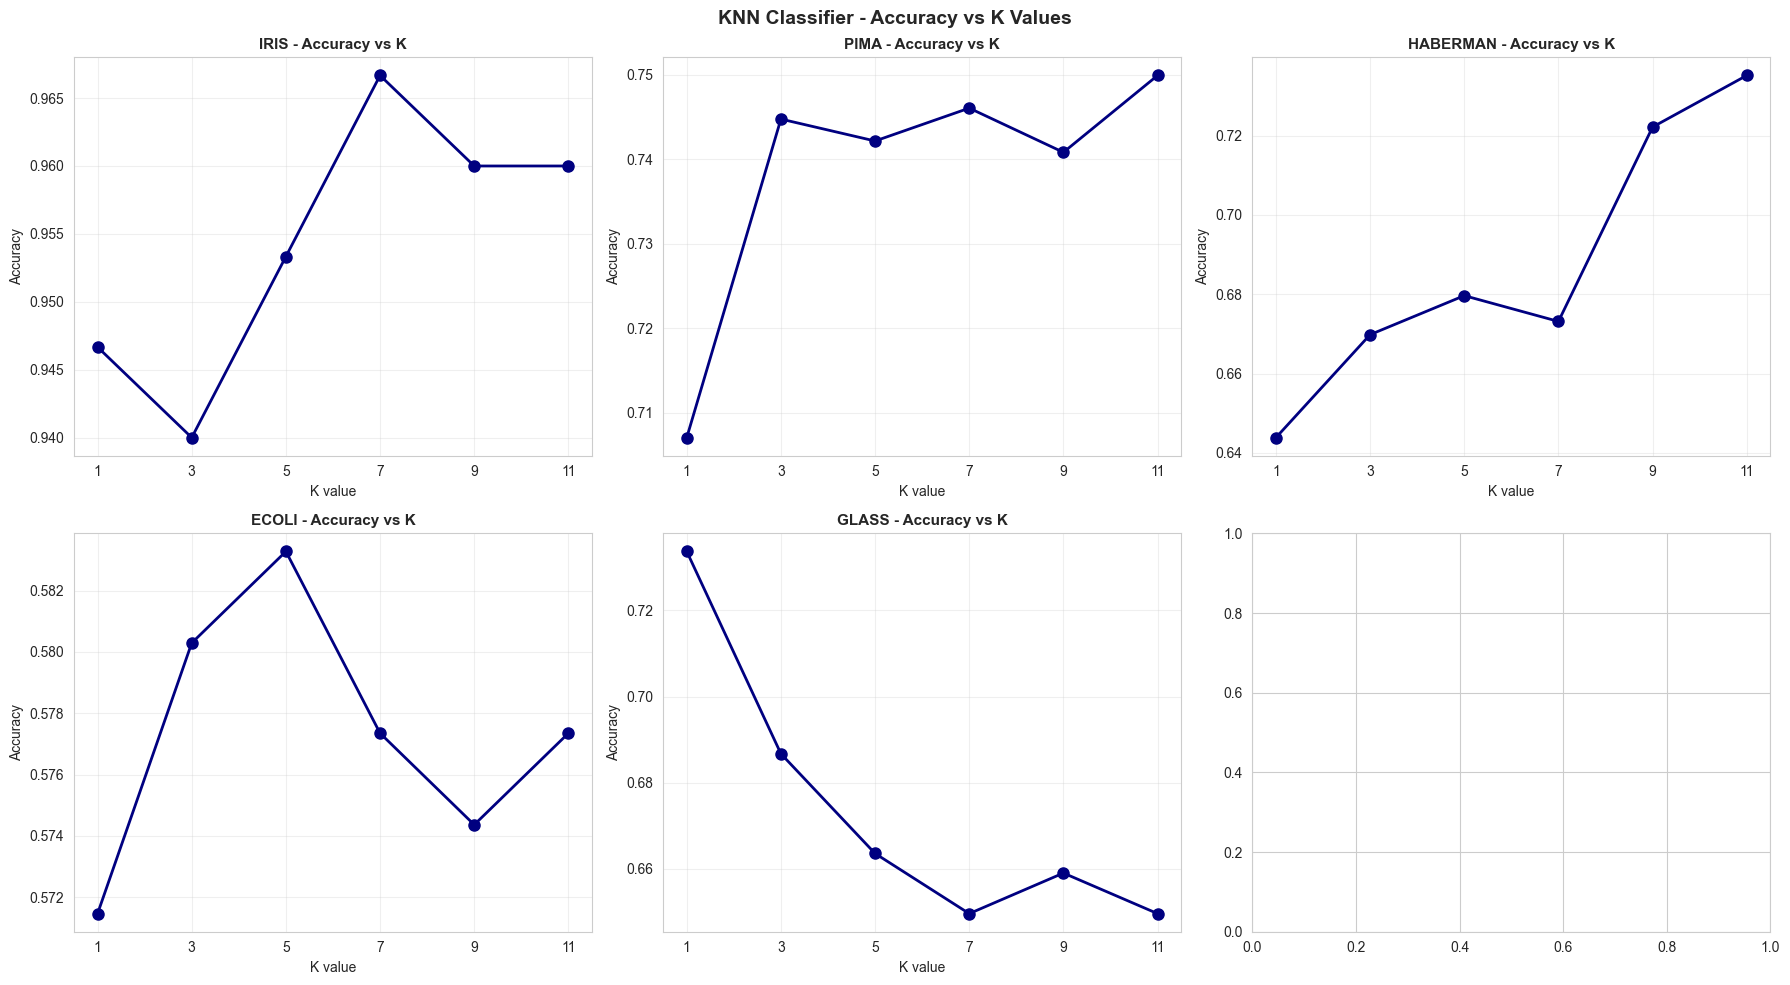

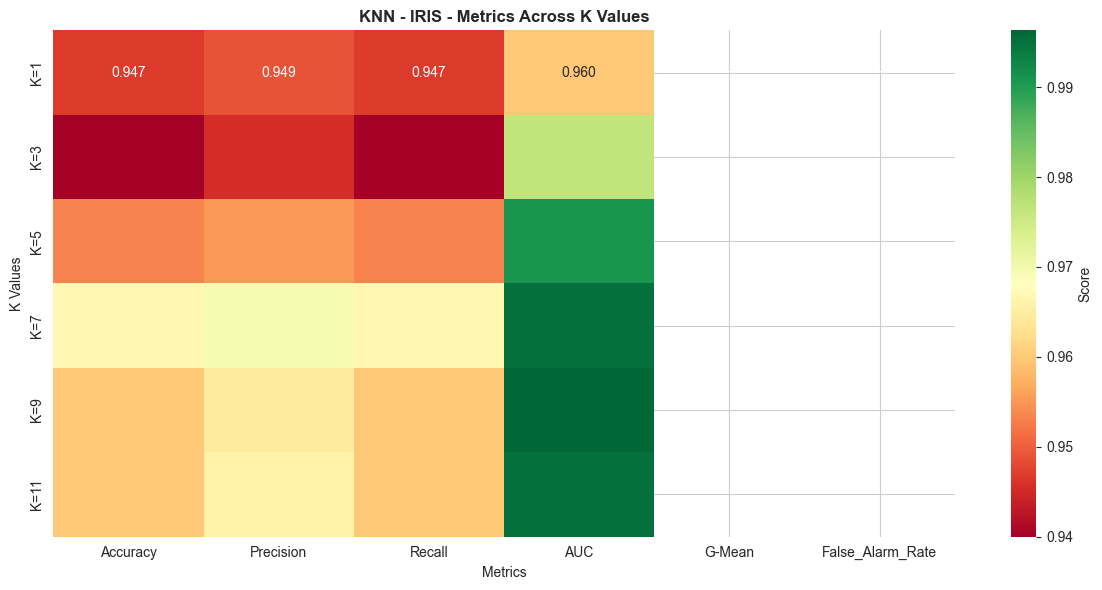

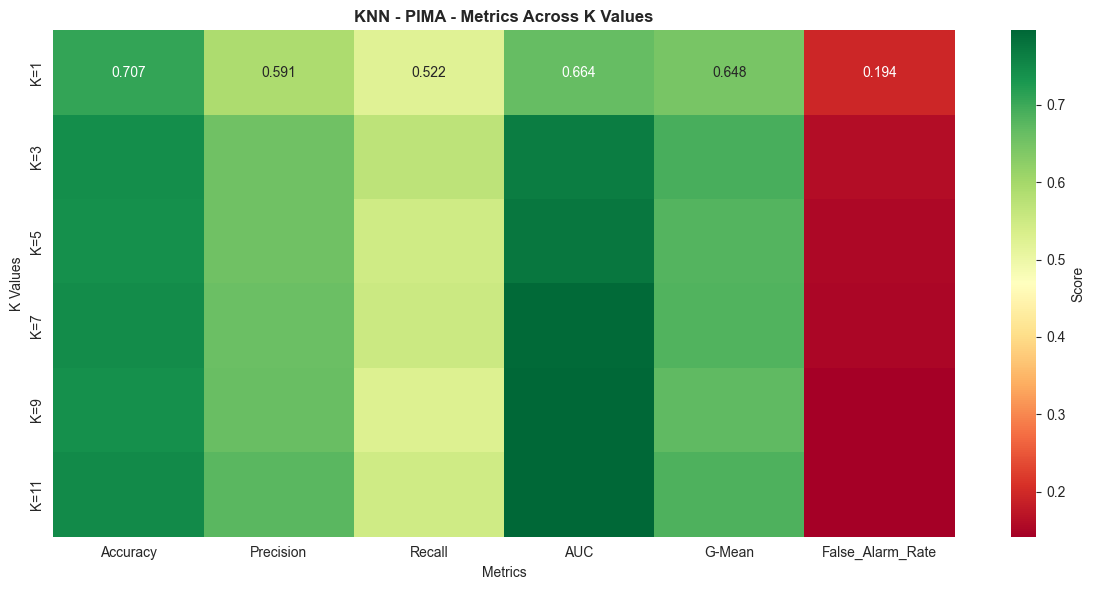

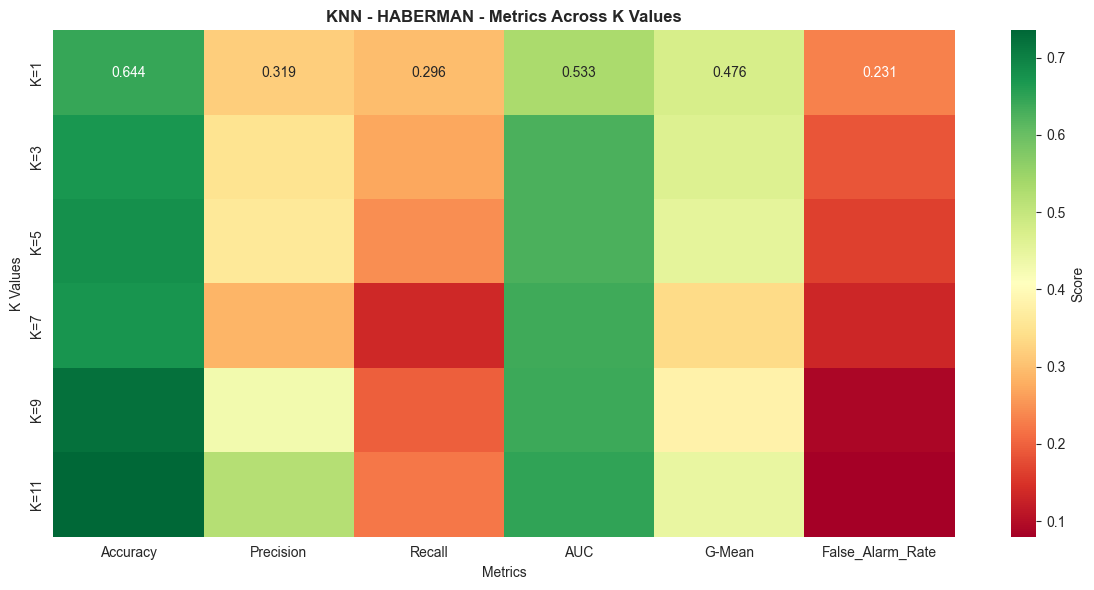

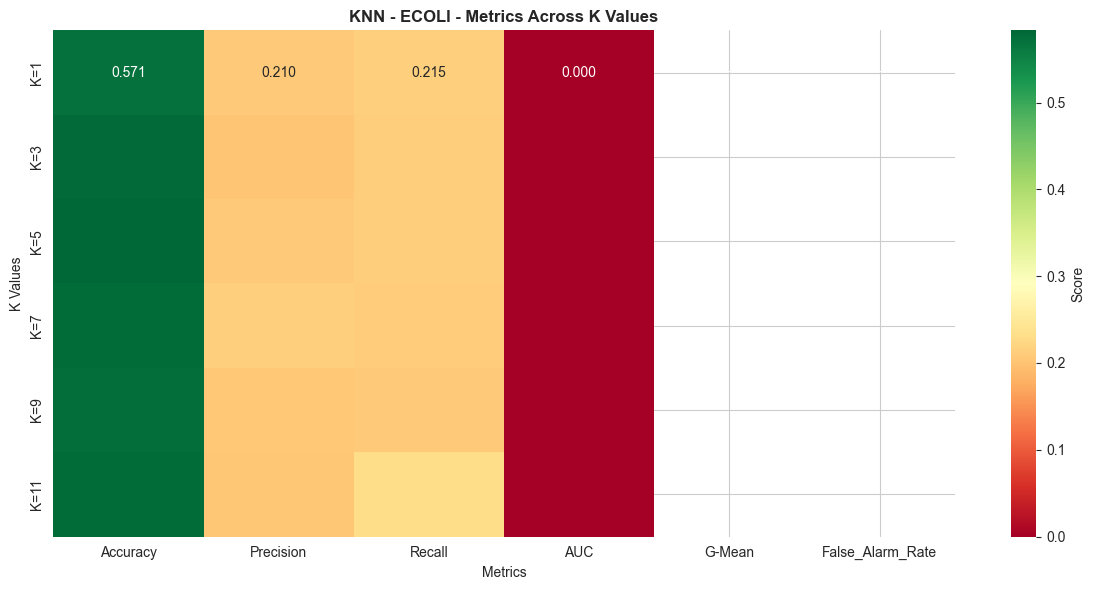

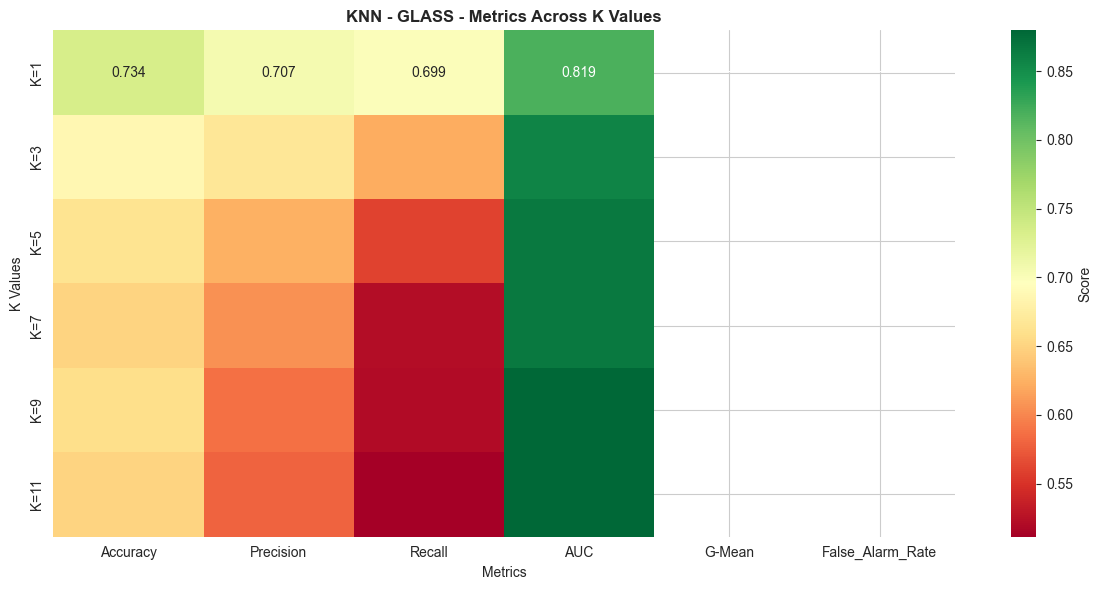

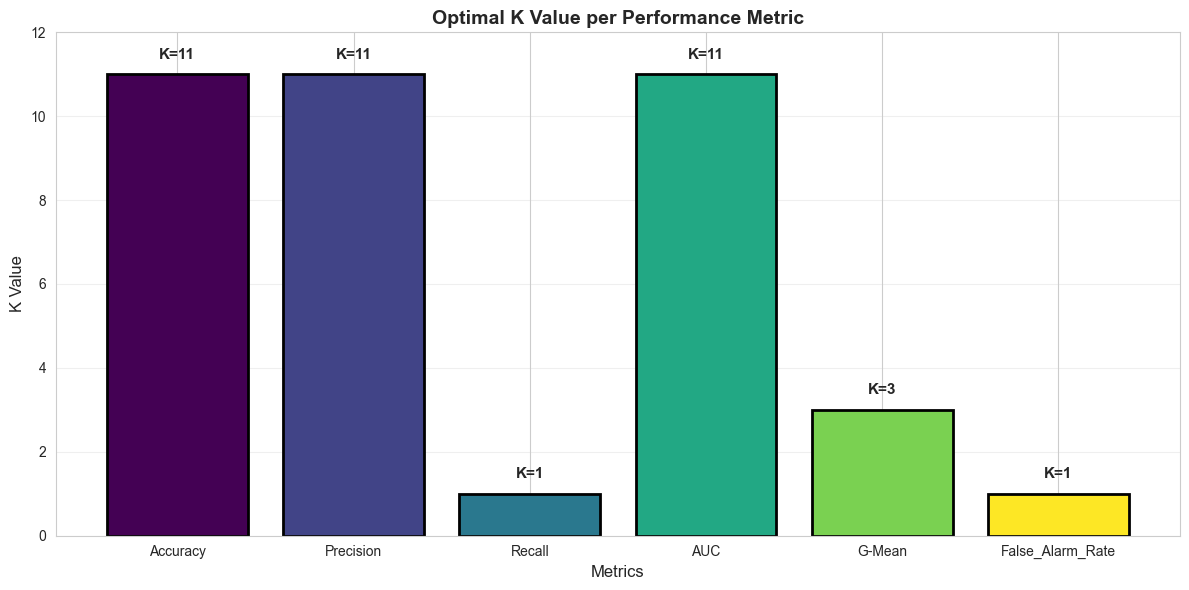

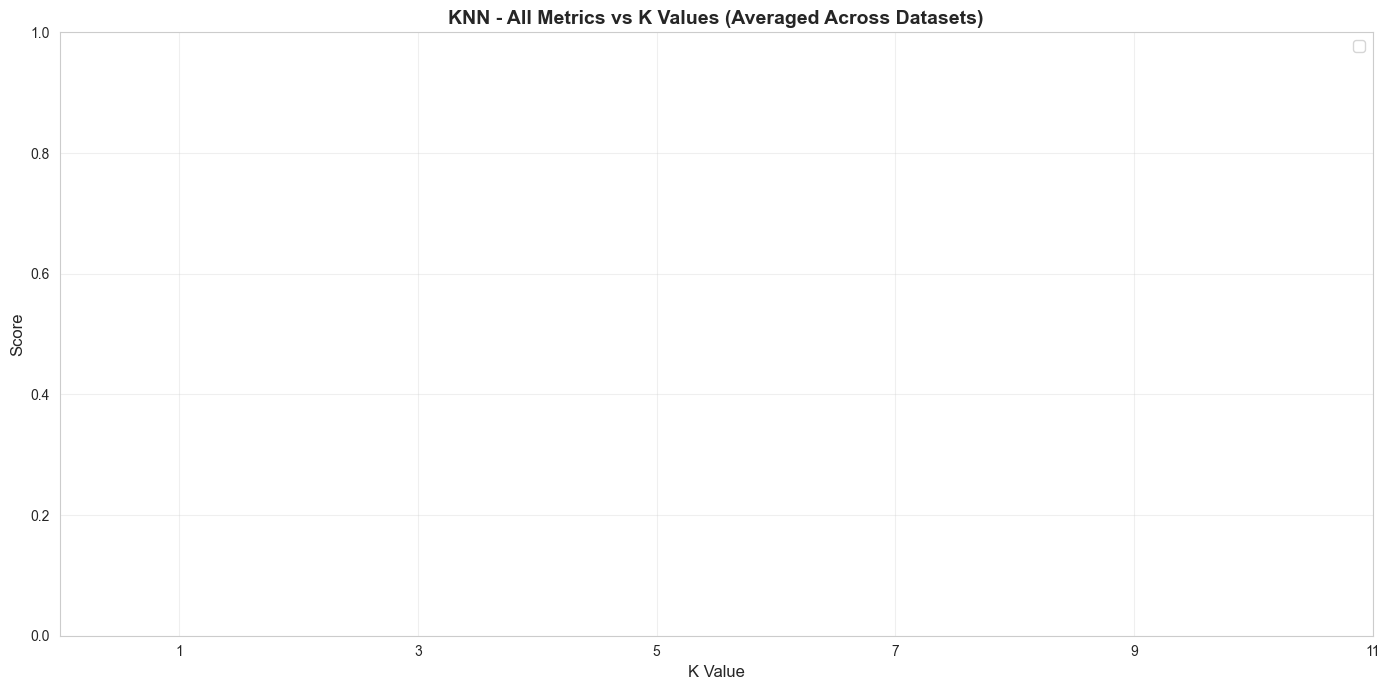


KNN HYPERPARAMETER TUNING VISUALIZATION SUMMARY


In [35]:
# Prepare comprehensive visualization data
metrics_list = ['Accuracy', 'Precision', 'Recall', 'AUC', 'G-Mean', 'False_Alarm_Rate']

# Figure 1: K-value vs Accuracy for each dataset
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, dataset_name in enumerate(DATASETS):
    if dataset_name in results:
        k_vals = []
        accuracies = []
        for k in K_VALUES:
            if k in results[dataset_name] and 'Accuracy' in results[dataset_name][k]:
                k_vals.append(k)
                accuracies.append(results[dataset_name][k]['Accuracy'])
        
        axes[idx].plot(k_vals, accuracies, marker='o', linewidth=2, markersize=8, color='navy')
        axes[idx].set_title(f'{dataset_name.upper()} - Accuracy vs K', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('K value', fontsize=10)
        axes[idx].set_ylabel('Accuracy', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_xticks(K_VALUES)

plt.suptitle('KNN Classifier - Accuracy vs K Values', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Figure 2: Performance metrics heatmap per dataset
for dataset_name in DATASETS:
    if dataset_name in results:
        metric_dict = {}
        for metric in metrics_list:
            metric_dict[metric] = []
        
        for k in K_VALUES:
            if k in results[dataset_name]:
                for metric in metrics_list:
                    if metric in results[dataset_name][k]:
                        metric_dict[metric].append(results[dataset_name][k][metric])
                    else:
                        metric_dict[metric].append(np.nan)
        
        heatmap_df = pd.DataFrame(metric_dict, index=[f'K={k}' for k in K_VALUES])
        
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdYlGn', cbar_kws={'label': 'Score'}, ax=ax)
        ax.set_title(f'KNN - {dataset_name.upper()} - Metrics Across K Values', fontsize=12, fontweight='bold')
        ax.set_xlabel('Metrics', fontsize=10)
        ax.set_ylabel('K Values', fontsize=10)
        plt.tight_layout()
        plt.show()

# Figure 3: Best K per metric across all datasets
fig, ax = plt.subplots(figsize=(12, 6))
best_k_data = []
for metric in metrics_list:
    best_k = None
    best_value = -float('inf')
    for k in K_VALUES:
        if k in overall_averages and metric in overall_averages[k]:
            value = overall_averages[k][metric]
            if not pd.isna(value) and value > best_value:
                best_value = value
                best_k = k
    if best_k is not None:
        best_k_data.append({'Metric': metric, 'Best K': best_k})

best_k_df = pd.DataFrame(best_k_data)
if len(best_k_df) > 0:
    colors = plt.cm.viridis(np.linspace(0, 1, len(best_k_df)))
    bars = ax.bar(best_k_df['Metric'], best_k_df['Best K'], color=colors, edgecolor='black', linewidth=2)
else:
    print("Warning: No valid metrics found for visualization")
    bars = []
ax.set_title('Optimal K Value per Performance Metric', fontsize=14, fontweight='bold')
ax.set_ylabel('K Value', fontsize=12)
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylim([0, 12])
ax.grid(axis='y', alpha=0.3)

for i, (bar, k_val) in enumerate(zip(bars, best_k_df['Best K'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.3, f'K={int(k_val)}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Figure 4: Multi-metric comparison across K values (averaged across datasets)
fig, ax = plt.subplots(figsize=(14, 7))

for metric in metrics_list:
    if metric in overall_averages:
        k_vals = []
        metric_vals = []
        for k in K_VALUES:
            if k in overall_averages[metric]:
                k_vals.append(k)
                metric_vals.append(overall_averages[metric][k])
        
        ax.plot(k_vals, metric_vals, marker='s', label=metric, linewidth=2.5, markersize=8)

ax.set_title('KNN - All Metrics vs K Values (Averaged Across Datasets)', fontsize=14, fontweight='bold')
ax.set_xlabel('K Value', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(K_VALUES)
ax.legend(loc='best', fontsize=11, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KNN HYPERPARAMETER TUNING VISUALIZATION SUMMARY")
print("="*70)